In [912]:
import pandas as pd
from itertools import cycle
import numpy as np
import seaborn as sns; sns.set()
from matplotlib import pyplot as plt    # we will also use the matplotlib visualisation library
import matplotlib.cm as cm
import warnings
warnings.simplefilter('ignore', category=UserWarning)  # suppresses warning message from Seaborn
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples

# no limit on visible columns 
pd.set_option('display.max_columns', None)

# command below ensures matplotlib output can be included in Notebook
%matplotlib inline

In [913]:
df = pd.read_csv("data/Per 100 Poss.csv") # load dataset into a dataframe

df.sample(5)

,seas_id,season,player_id,player,birth_year,pos,age,experience,lg,tm,g,gs,mp,fg_per_100_poss,fga_per_100_poss,fg_percent,x3p_per_100_poss,x3pa_per_100_poss,x3p_percent,x2p_per_100_poss,x2pa_per_100_poss,x2p_percent,ft_per_100_poss,fta_per_100_poss,ft_percent,orb_per_100_poss,drb_per_100_poss,trb_per_100_poss,ast_per_100_poss,stl_per_100_poss,blk_per_100_poss,tov_per_100_poss,pf_per_100_poss,pts_per_100_poss,o_rtg,d_rtg
17612,13319,1993,2306,Greg Dreiling,NaN,C,30,7,NBA,IND,43,0.0,239,4.0,12.1,0.328,0.0,0.8,0.000,4.0,11.3,0.352,1.7,3.1,0.533,5.4,8.4,13.8,1.7,1.0,1.7,1.9,12.6,9.6,90.0,108.0
2273,28444,2020,4492,Derrick White,NaN,SG,25,3,NBA,SAS,68,20.0,1677,7.2,15.7,0.458,2.3,6.2,0.366,5.0,9.6,0.518,5.1,6.0,0.853,1.0,5.4,6.4,6.9,1.3,1.7,2.5,4.3,21.8,118.0,114.0
24672,6162,1975,1355,Dean Meminger,NaN,PG,26,4,NBA,ATL,80,NaN,2177,4.8,10.4,0.466,NaN,NaN,NaN,4.8,10.4,0.466,3.5,5.5,0.639,1.7,2.7,4.4,8.2,2.4,0.2,NaN,3.3,13.2,NaN,101.0
3550,26990,2018,4225,Bruno Caboclo,NaN,SF,22,4,NBA,SAC,10,0.0,100,4.6,14.7,0.310,1.5,7.6,0.200,3.0,7.1,0.429,2.5,3.0,0.833,3.5,7.1,10.6,1.5,1.0,2.0,2.0,3.5,13.1,89.0,111.0
23180,7758,1979,1447,George Gervin,1952.0,SF,26,7,NBA,SAS,80,NaN,2888,14.2,26.3,0.541,NaN,NaN,NaN,14.2,26.3,0.541,7.1,8.6,0.826,2.1,3.9,6.0,3.3,2.1,1.4,4.3,4.1,35.6,112.0,103.0


In [914]:
df.shape # returns the shape of data - rows and columns

(25412, 36)

In [915]:
# removing players from seasons prior to 2013 - prior to the modern era of basketball
df = df.drop(df[df.season < 2013].index)

# Pre-processing data

## Removing unecessary text from columns

In [916]:
df.columns # list all the different columns

Index(['seas_id', 'season', 'player_id', 'player', 'birth_year', 'pos', 'age',
       'experience', 'lg', 'tm', 'g', 'gs', 'mp', 'fg_per_100_poss',
       'fga_per_100_poss', 'fg_percent', 'x3p_per_100_poss',
       'x3pa_per_100_poss', 'x3p_percent', 'x2p_per_100_poss',
       'x2pa_per_100_poss', 'x2p_percent', 'ft_per_100_poss',
       'fta_per_100_poss', 'ft_percent', 'orb_per_100_poss',
       'drb_per_100_poss', 'trb_per_100_poss', 'ast_per_100_poss',
       'stl_per_100_poss', 'blk_per_100_poss', 'tov_per_100_poss',
       'pf_per_100_poss', 'pts_per_100_poss', 'o_rtg', 'd_rtg'],
      dtype='object')

In [917]:
for col in df.columns:
  # replacing percent with % sign
  col_modified = col.replace('_percent', '%')
  # remove _per_100_poss from columns that have it
  if "_per_100_poss" in col:
    col_modified = col.split("_")[0]
    
  df = df.rename(columns = {col:col_modified})

df.columns


Index(['seas_id', 'season', 'player_id', 'player', 'birth_year', 'pos', 'age',
       'experience', 'lg', 'tm', 'g', 'gs', 'mp', 'fg', 'fga', 'fg%', 'x3p',
       'x3pa', 'x3p%', 'x2p', 'x2pa', 'x2p%', 'ft', 'fta', 'ft%', 'orb', 'drb',
       'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 'o_rtg', 'd_rtg'],
      dtype='object')

## Size of data and variable types

In [918]:
df.dtypes # returns the datatype of each column

seas_id         int64
season          int64
player_id       int64
player         object
birth_year    float64
pos            object
age             int64
experience      int64
lg             object
tm             object
g               int64
gs            float64
mp              int64
fg            float64
fga           float64
fg%           float64
x3p           float64
x3pa          float64
x3p%          float64
x2p           float64
x2pa          float64
x2p%          float64
ft            float64
fta           float64
ft%           float64
orb           float64
drb           float64
trb           float64
ast           float64
stl           float64
blk           float64
tov           float64
pf            float64
pts           float64
o_rtg         float64
d_rtg         float64
dtype: object

In [919]:
df.shape # returns the shape of data - rows and columns

(7150, 36)

In [920]:
df.index

RangeIndex(start=0, stop=7150, step=1)

## Preliminary exploration of values in the data

In [921]:
df.sample(10) # view random rows

,seas_id,season,player_id,player,birth_year,pos,age,experience,lg,tm,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg
5910,25689,2015,4294,Tim Frazier,NaN,PG,24,1,NBA,PHI,6,3.0,171,3.8,12.6,0.302,0.9,3.2,0.273,2.9,9.4,0.313,1.5,4.4,0.333,1.2,4.4,5.6,12.6,1.8,0.0,5.3,4.7,10.0,79.0,108.0
3955,27395,2018,4278,Nerlens Noel,NaN,C,23,4,NBA,DAL,30,6.0,472,5.8,11.2,0.524,0.0,0.1,0.000,5.8,11.1,0.529,2.2,3.0,0.750,5.1,12.8,17.9,2.1,3.3,2.3,2.8,6.3,13.9,109.0,100.0
2357,28528,2020,4627,Isaiah Hartenstein,NaN,C,21,2,NBA,HOU,23,2.0,266,7.7,11.7,0.657,0.0,0.9,0.000,7.7,10.8,0.710,3.3,4.9,0.679,5.0,10.6,15.7,3.1,1.6,2.1,2.8,7.1,18.6,128.0,107.0
1997,29524,2021,4443,Rodney McGruder,NaN,SG,29,5,NBA,DET,16,2.0,194,9.4,17.7,0.529,2.8,6.1,0.458,6.6,11.6,0.565,1.5,2.0,0.750,2.0,3.5,5.6,4.0,2.0,0.3,1.8,3.0,23.0,120.0,114.0
1419,28946,2021,4463,Abdel Nader,NaN,SF,27,4,NBA,PHO,24,0.0,355,7.9,16.1,0.491,2.5,6.0,0.419,5.4,10.2,0.534,3.9,5.1,0.757,1.0,7.6,8.6,2.6,1.4,1.3,2.6,4.7,22.2,111.0,111.0
6150,24667,2014,4006,Enes Freedom,NaN,C,21,3,NBA,UTA,80,37.0,2138,10.3,21.0,0.491,0.0,0.0,0.000,10.3,20.9,0.492,3.7,5.0,0.730,5.5,9.2,14.7,1.8,0.7,1.0,3.5,5.7,24.3,102.0,112.0
5477,25256,2015,4237,Doug McDermott,NaN,SF,23,1,NBA,CHI,36,0.0,321,6.9,17.2,0.402,2.1,6.6,0.317,4.8,10.6,0.455,1.6,2.4,0.667,1.0,6.0,6.9,1.0,0.6,0.2,2.7,4.7,17.6,89.0,108.0
1783,29310,2021,4419,Juancho Hernangómez,NaN,PF,25,5,NBA,MIN,52,6.0,900,6.8,15.7,0.435,2.9,8.8,0.327,3.9,6.9,0.573,3.1,5.1,0.619,2.4,8.4,10.8,1.8,1.0,0.4,1.4,2.7,19.7,111.0,117.0
472,30930,2023,4124,Patrick Beverley,NaN,PG,34,11,NBA,LAL,45,45.0,1211,3.8,9.4,0.402,2.1,6.2,0.348,1.6,3.2,0.506,1.5,1.9,0.780,0.9,4.5,5.5,4.6,1.6,1.0,1.6,4.8,11.2,112.0,115.0
6488,25005,2014,3714,Ryan Hollins,NaN,PF,29,8,NBA,LAC,61,0.0,482,5.5,7.5,0.736,0.0,0.0,NaN,5.5,7.5,0.736,3.6,5.8,0.625,3.2,6.1,9.3,0.8,0.9,3.2,3.0,9.0,14.6,117.0,105.0


In [922]:
df.head() # view first rows

,seas_id,season,player_id,player,birth_year,pos,age,experience,lg,tm,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg
0,30458,2023,5025,A.J. Green,NaN,SG,23,1,NBA,MIL,26,0.0,244,8.3,18.1,0.457,6.5,15.1,0.429,1.8,3.0,0.600,0.8,0.8,1.000,0.8,4.7,5.5,2.4,1.0,0.0,1.4,4.7,23.8,125.0,114.0
1,30459,2023,5026,A.J. Lawson,NaN,SG,22,1,NBA,TOT,13,0.0,63,10.3,20.7,0.500,5.6,12.7,0.438,4.8,7.9,0.600,0.8,2.4,0.333,1.6,6.4,7.9,0.8,0.8,0.0,0.8,6.4,27.0,118.0,118.0
2,30460,2023,5026,A.J. Lawson,NaN,SG,22,1,NBA,MIN,1,0.0,2,23.7,23.7,1.000,0.0,0.0,NaN,23.7,23.7,1.000,0.0,0.0,NaN,0.0,23.7,23.7,0.0,0.0,0.0,0.0,23.7,47.4,200.0,106.0
3,30461,2023,5026,A.J. Lawson,NaN,SG,22,1,NBA,DAL,12,0.0,61,9.9,20.5,0.480,5.8,13.2,0.438,4.1,7.4,0.556,0.8,2.5,0.333,1.6,5.8,7.4,0.8,0.8,0.0,0.8,5.8,26.3,116.0,119.0
4,30462,2023,4219,Aaron Gordon,NaN,PF,27,9,NBA,DEN,49,49.0,1483,10.6,18.0,0.587,1.6,4.1,0.397,9.0,13.9,0.644,5.0,8.0,0.623,3.9,7.2,11.0,4.6,1.3,1.3,2.6,3.0,27.8,127.0,114.0


In [923]:
df.tail() # view last rows

,seas_id,season,player_id,player,birth_year,pos,age,experience,lg,tm,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg
7145,24478,2013,3492,Willie Green,NaN,SG,31,10,NBA,LAC,72,60.0,1188,7.9,17.1,0.461,3.1,7.4,0.428,4.7,9.8,0.486,1.0,1.4,0.719,0.8,3.5,4.3,2.4,1.3,0.5,1.4,4.3,19.9,113.0,108.0
7146,24479,2013,3793,Wilson Chandler,NaN,PF,25,6,NBA,DEN,43,8.0,1079,9.8,21.3,0.462,2.4,5.9,0.413,7.4,15.4,0.480,4.1,5.2,0.793,2.1,8.1,10.2,2.7,2.1,0.6,2.8,5.6,26.2,110.0,105.0
7147,24480,2013,3980,Xavier Henry,NaN,SF,21,3,NBA,NOH,50,2.0,625,5.7,14.0,0.410,0.3,1.0,0.364,5.4,13.0,0.413,5.0,8.0,0.630,1.8,6.0,7.8,1.1,1.4,0.4,2.7,6.2,16.8,94.0,111.0
7148,24481,2013,3363,Zach Randolph,NaN,PF,31,12,NBA,MEM,76,75.0,2607,9.8,21.3,0.460,0.0,0.5,0.087,9.8,20.8,0.469,4.7,6.2,0.750,6.5,11.3,17.8,2.2,1.3,0.6,3.1,3.7,24.3,106.0,99.0
7149,24482,2013,3494,Zaza Pachulia,NaN,C,28,10,NBA,ATL,52,15.0,1134,5.2,11.0,0.473,0.0,0.1,0.000,5.2,10.9,0.479,3.6,4.7,0.757,6.0,9.3,15.4,3.6,1.6,0.5,3.2,5.8,14.0,108.0,104.0


In [924]:
df.describe() # view the description of the numerical values in the data set 

,seas_id,season,player_id,birth_year,age,experience,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg
count,7150.000000,7150.000000,7150.000000,53.000000,7150.000000,7150.000000,7150.000000,7150.000000,7150.000000,7149.000000,7149.000000,7099.000000,7149.000000,7149.000000,6491.000000,7149.000000,7149.000000,7037.000000,7149.000000,7149.000000,6709.000000,7149.000000,7149.000000,7149.000000,7149.000000,7149.000000,7149.000000,7149.000000,7149.000000,7149.000000,7116.000000,7149.000000
mean,27484.500000,2018.191608,4186.560559,1986.981132,26.226713,5.459720,42.595245,19.522657,961.848811,7.153854,16.336341,0.439344,1.852399,5.591481,0.304251,5.301637,10.745321,0.490230,3.027263,4.109036,0.737250,2.281522,6.660330,8.941376,4.230648,1.556553,0.984068,2.702756,4.626549,19.186502,105.446318,109.792978
std,2064.171545,3.135926,424.977956,5.238506,4.157743,4.089226,25.501463,25.499963,797.908434,2.972217,5.303745,0.113652,1.641012,4.086564,0.144262,2.998224,5.113191,0.126909,2.339098,2.952030,0.152881,2.320312,3.324658,4.763022,2.950488,1.168565,1.102453,1.650478,2.569354,7.635843,20.088240,5.236136
min,23910.000000,2013.000000,2863.000000,1975.000000,19.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,45.000000
25%,25697.250000,2015.000000,3891.000000,1983.000000,23.000000,2.000000,20.000000,0.000000,233.250000,5.500000,12.900000,0.396000,0.400000,2.400000,0.260000,3.300000,7.300000,0.442000,1.600000,2.300000,0.667000,0.800000,4.500000,5.600000,2.200000,1.000000,0.300000,1.800000,3.300000,14.800000,99.000000,107.000000
50%,27484.500000,2018.000000,4188.500000,1987.000000,26.000000,4.000000,45.000000,6.000000,787.000000,7.000000,15.900000,0.438000,1.800000,5.700000,0.333000,5.000000,10.400000,0.494000,2.700000,3.700000,0.762000,1.500000,6.100000,7.800000,3.400000,1.400000,0.700000,2.500000,4.200000,18.700000,107.000000,110.000000
75%,29271.750000,2021.000000,4490.000000,1990.000000,29.000000,8.000000,66.000000,34.000000,1571.750000,8.800000,19.500000,0.488000,2.900000,8.200000,0.378000,6.900000,13.700000,0.547000,4.000000,5.500000,0.833000,3.300000,8.400000,11.600000,5.700000,1.900000,1.300000,3.400000,5.500000,23.300000,114.000000,113.000000
max,31059.000000,2023.000000,5100.000000,2002.000000,43.000000,22.000000,83.000000,82.000000,3167.000000,52.600000,53.100000,1.000000,50.100000,50.100000,1.000000,52.600000,53.100000,1.000000,49.700000,51.400000,1.000000,52.600000,49.700000,53.100000,49.000000,25.000000,24.100000,38.400000,99.800000,150.400000,300.000000,127.000000


In [925]:
 # get info about each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7150 entries, 0 to 7149
Data columns (total 36 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   seas_id     7150 non-null   int64  
 1   season      7150 non-null   int64  
 2   player_id   7150 non-null   int64  
 3   player      7150 non-null   object 
 4   birth_year  53 non-null     float64
 5   pos         7150 non-null   object 
 6   age         7150 non-null   int64  
 7   experience  7150 non-null   int64  
 8   lg          7150 non-null   object 
 9   tm          7150 non-null   object 
 10  g           7150 non-null   int64  
 11  gs          7150 non-null   float64
 12  mp          7150 non-null   int64  
 13  fg          7149 non-null   float64
 14  fga         7149 non-null   float64
 15  fg%         7099 non-null   float64
 16  x3p         7149 non-null   float64
 17  x3pa        7149 non-null   float64
 18  x3p%        6491 non-null   float64
 19  x2p         7149 non-null  

## Removing unreliable data

In [926]:
# get the number of missing data points per column
df.isnull().sum()

seas_id          0
season           0
player_id        0
player           0
birth_year    7097
pos              0
age              0
experience       0
lg               0
tm               0
g                0
gs               0
mp               0
fg               1
fga              1
fg%             51
x3p              1
x3pa             1
x3p%           659
x2p              1
x2pa             1
x2p%           113
ft               1
fta              1
ft%            441
orb              1
drb              1
trb              1
ast              1
stl              1
blk              1
tov              1
pf               1
pts              1
o_rtg           34
d_rtg            1
dtype: int64

In [927]:
# remove players that played less than 30 total games, 82 games total per season
df = df.drop(df[df.g < 30].index)

# remove players that played less than 1/4 of possible game time
# each game is 48 min long, 1/4 = 12 min
df = df.drop(df[df.mp < (12*82)].index)

# create copy of original dataframe for later use
df_copy = df.copy()

# get the number of missing data points per column
df.isnull().sum()

seas_id          0
season           0
player_id        0
player           0
birth_year    3077
pos              0
age              0
experience       0
lg               0
tm               0
g                0
gs               0
mp               0
fg               0
fga              0
fg%              0
x3p              0
x3pa             0
x3p%           110
x2p              0
x2pa             0
x2p%             0
ft               0
fta              0
ft%              0
orb              0
drb              0
trb              0
ast              0
stl              0
blk              0
tov              0
pf               0
pts              0
o_rtg            0
d_rtg            0
dtype: int64

## Removing irrelevant features

In [928]:
# drop columns that are not player performance stats
df = df.drop(
  ['seas_id', 'birth_year', 'lg','season','player','player_id','experience','tm','age','pos'], axis=1)

# drop columns that do not give information about the role of the player on the court
df = df.drop(
  ['g', 'gs', 'mp'], axis=1)

df.columns


Index(['fg', 'fga', 'fg%', 'x3p', 'x3pa', 'x3p%', 'x2p', 'x2pa', 'x2p%', 'ft',
       'fta', 'ft%', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf',
       'pts', 'o_rtg', 'd_rtg'],
      dtype='object')

## Checking for uniqueness of data

In [929]:
# print sum of unique values for each column
for col in df.columns:
  print(f"{col}: {len(df[col].unique())}")

fg: 126
fga: 235
fg%: 333
x3p: 67
x3pa: 161
x3p%: 297
x2p: 134
x2pa: 245
x2p%: 334
ft: 119
fta: 138
ft%: 440
orb: 82
drb: 143
trb: 195
ast: 147
stl: 39
blk: 56
tov: 65
pf: 77
pts: 334
o_rtg: 62
d_rtg: 30


## Filling Null data

In [930]:
# get the number of missing data points per column
df.isnull().sum()

fg         0
fga        0
fg%        0
x3p        0
x3pa       0
x3p%     110
x2p        0
x2pa       0
x2p%       0
ft         0
fta        0
ft%        0
orb        0
drb        0
trb        0
ast        0
stl        0
blk        0
tov        0
pf         0
pts        0
o_rtg      0
d_rtg      0
dtype: int64

### Filling NaN x3p percent

In [931]:
# replacing NaN values for 3 point shots % with 0
df['x3p%'] = df['x3p%'].fillna(0)

# no more missing values
df.isnull().sum()

fg       0
fga      0
fg%      0
x3p      0
x3pa     0
x3p%     0
x2p      0
x2pa     0
x2p%     0
ft       0
fta      0
ft%      0
orb      0
drb      0
trb      0
ast      0
stl      0
blk      0
tov      0
pf       0
pts      0
o_rtg    0
d_rtg    0
dtype: int64

In [932]:
df.sample(10) # view first 10 rows

,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg
2351,10.3,16.7,0.621,0.1,0.2,0.571,10.3,16.5,0.622,3.9,5.7,0.686,6.1,15.4,21.5,1.9,0.6,4.7,2.8,4.7,24.7,125.0,107.0
5862,8.9,18.6,0.476,1.8,4.9,0.376,7.0,13.8,0.511,2.2,2.6,0.836,3.2,8.6,11.8,1.3,0.7,3.7,2.3,4.6,21.7,109.0,104.0
4646,8.7,18.0,0.481,3.5,8.3,0.425,5.2,9.8,0.528,2.2,2.6,0.850,0.6,4.0,4.6,4.8,2.0,0.2,2.4,3.2,23.0,113.0,110.0
1110,6.5,15.4,0.423,4.4,10.5,0.423,2.1,5.0,0.423,0.8,1.1,0.750,1.4,6.2,7.7,7.2,2.6,1.2,3.3,3.4,18.3,110.0,111.0
4562,9.8,15.9,0.617,0.1,0.4,0.333,9.7,15.5,0.624,4.6,7.9,0.589,3.8,7.5,11.3,2.6,2.2,1.6,2.9,6.5,24.4,118.0,106.0
3732,9.2,20.0,0.460,4.4,10.5,0.420,4.8,9.5,0.504,4.5,5.0,0.904,0.2,3.8,4.0,4.8,0.8,0.1,2.3,2.8,27.2,119.0,110.0
6839,6.9,16.0,0.434,3.0,8.2,0.372,3.9,7.8,0.498,2.8,3.2,0.870,0.5,3.4,3.9,4.9,1.6,0.3,2.5,2.7,19.7,107.0,107.0
1808,7.3,13.7,0.533,1.7,3.9,0.444,5.6,9.8,0.568,1.2,2.1,0.571,2.8,6.3,9.1,5.1,1.8,0.6,2.5,4.8,17.5,116.0,114.0
5501,8.3,18.6,0.447,1.6,4.8,0.324,6.8,13.8,0.491,6.3,7.9,0.800,1.3,6.2,7.5,8.8,2.3,0.8,4.9,3.4,24.5,107.0,106.0
2165,9.0,15.5,0.580,0.0,0.2,0.286,9.0,15.4,0.583,4.4,7.2,0.621,2.7,8.0,10.7,10.9,2.9,0.8,4.8,4.5,22.5,116.0,106.0


## Scaling data between 0 and 1

In [933]:
# make copy of dataframe
X = df.copy()
column_names = X.columns

# apply MinMaxScaling
scaler = MinMaxScaler().fit(X)
X = scaler.transform(X)
X = pd.DataFrame(X, columns=column_names)

# show newly scaled dataframe
X.describe()

,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg
count,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000
mean,0.413918,0.427898,0.343212,0.285336,0.332767,0.314129,0.373270,0.385169,0.436837,0.232994,0.225552,0.665312,0.215152,0.318016,0.298202,0.289634,0.325848,0.150391,0.325753,0.346453,0.368883,0.417203,0.495637
std,0.160828,0.164134,0.136505,0.190825,0.206536,0.121910,0.172266,0.174685,0.135279,0.143795,0.135665,0.137387,0.186339,0.178509,0.186292,0.185478,0.146134,0.132453,0.142553,0.129601,0.152590,0.121226,0.157349
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.297872,0.305263,0.253275,0.135135,0.181818,0.304000,0.243243,0.258303,0.342048,0.130357,0.125683,0.594828,0.079545,0.181818,0.153846,0.147436,0.230769,0.061538,0.219178,0.252747,0.257212,0.342857,0.379310
50%,0.397163,0.417544,0.315502,0.297297,0.352273,0.348000,0.358108,0.372694,0.422658,0.200000,0.202186,0.688218,0.136364,0.272727,0.239819,0.230769,0.307692,0.107692,0.301370,0.329670,0.350962,0.414286,0.517241
75%,0.517730,0.540351,0.399563,0.418919,0.477273,0.380000,0.486486,0.498155,0.511983,0.305357,0.295082,0.764368,0.303977,0.428571,0.411765,0.397436,0.410256,0.184615,0.410959,0.417582,0.461538,0.485714,0.620690
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [934]:
X.sample(5)

,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg
2581,0.425532,0.505263,0.248908,0.513514,0.522727,0.411,0.277027,0.343173,0.259259,0.378571,0.316940,0.830460,0.022727,0.084416,0.058824,0.538462,0.307692,0.015385,0.397260,0.340659,0.466346,0.471429,0.344828
265,0.439716,0.484211,0.296943,0.540541,0.602273,0.375,0.270270,0.269373,0.466231,0.228571,0.207650,0.755747,0.170455,0.266234,0.244344,0.096154,0.256410,0.215385,0.164384,0.384615,0.432692,0.471429,0.655172
1423,0.482270,0.508772,0.329694,0.486486,0.505682,0.409,0.337838,0.357934,0.407407,0.164286,0.131148,0.853448,0.045455,0.590909,0.420814,0.185897,0.205128,0.184615,0.123288,0.329670,0.430288,0.442857,0.448276
638,0.567376,0.575439,0.362445,0.472973,0.545455,0.366,0.425676,0.402214,0.533769,0.564286,0.497268,0.793103,0.102273,0.532468,0.402715,0.897436,0.358974,0.153846,0.657534,0.241758,0.620192,0.600000,0.551724
867,0.496454,0.491228,0.371179,0.283784,0.340909,0.344,0.452703,0.446494,0.492375,0.314286,0.295082,0.698276,0.113636,0.305195,0.248869,0.564103,0.333333,0.107692,0.506849,0.296703,0.449519,0.442857,0.310345


## Reducing dimensions with PCA

### Choosing number of components

Text(0, 0.5, 'cumulative explained variance')

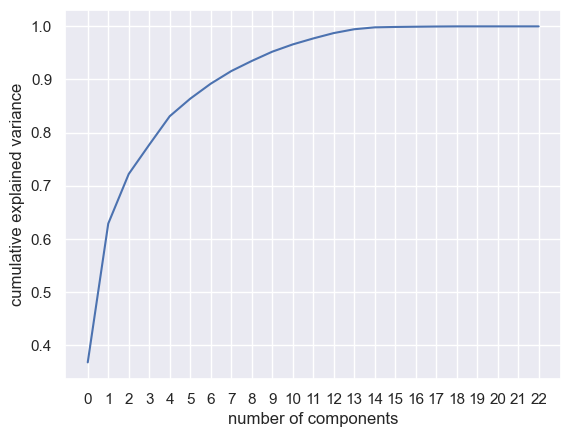

In [935]:
sns.set()

pca = PCA().fit(X)
number_components = range(len(pca.explained_variance_ratio_))

plt.plot(number_components, np.cumsum(pca.explained_variance_ratio_)) #plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xticks(number_components)  
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

### Reducing to 13 dimensions

In [936]:
# reduce to 13 dimensions make clustering more effective
X_PCA = PCA(13).fit_transform(X)

# Machine learning models

## Kmeans

In [937]:
def kmeans(X, n_clusters):
    """
        Use KMeans to group the data into a specified number of clusters
        
        :param DataFrame X: scaled data to be clustered
        :param int n_clusters: number of clusters required
    """
    
    # Instantiate the model with a particular number of clusters and other parameters
    model = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=200,
                   n_init=10, random_state=0)

    # fit the model ... i.e. find the n clusters
    model.fit(X)
    
    # Return key cluster information: score, centres and labels
    
    return (model.inertia_, model.cluster_centers_, model.labels_)

In [938]:
def gmm(X, n_clusters):
    """
        Use GMM to group the data into a specified number of clusters
        
        :param DataFrame X: scaled data to be clustered
        :param int n_clusters: number of clusters required
    """
    
    # Model the data with the specified number of multivariate Gaussians

    model = GaussianMixture(n_components=n_clusters, random_state=123,
                            n_init=10)
    
    # fit the model ... i.e. find n Gaussians that fit the data the best

    model.fit(X)

    # Use BIC score to evaluate fit ... could use aic() instead
    # or model.score(X) which gives score of each data row individually

    score = model.bic(X)
    
    # need to call predict(X) to determine which cluster that each point
    # is most likely to belong to

    labels = model.predict(X)

    return (score, model.means_, labels)
    

# Selecting optimal number of clusters 

In [939]:
# 
kbest_scores = []
gmm_scores = []
kmeans_silhouette_scores = []
gmm_silhouette_scores = []

for i in range(2, 11):
      score, _, labels = kmeans(X_PCA, i)
      sizes = pd.Series(labels).value_counts().to_dict()

      # kmeans inertia score
      print('KMeans has {} clusters with sizes {} with score {:.2f}'
            .format(i, sizes, score))
      kbest_scores.append(score)

      # kmeans silhouette score
      kmeans_silhouette_avg = silhouette_score(X_PCA, labels)
      print("For n_clusters = {}, kmeans silhouette score is {})\n".format(i, kmeans_silhouette_avg))
      kmeans_silhouette_scores.append(kmeans_silhouette_avg)

      # gmm BIC score
      score, _, labels = gmm(X_PCA, i)
      sizes = pd.Series(labels).value_counts().to_dict()

      print('GMM has {} clusters with sizes {} with score {:.2f}'
            .format(i, sizes, score))
      gmm_scores.append(score)
      
      # gmm silhouette score
      gmm_silhouette_avg = silhouette_score(X_PCA, labels)
      print("For n_clusters = {}, gmm silhouette score is {})\n".format(i, gmm_silhouette_avg))
      gmm_silhouette_scores.append(gmm_silhouette_avg)

KMeans has 2 clusters with sizes {0: 2289, 1: 801} with score 1272.69
For n_clusters = 2, kmeans silhouette score is 0.30922474320268634)

GMM has 2 clusters with sizes {0: 2178, 1: 912} with score -46774.92
For n_clusters = 2, gmm silhouette score is 0.2716662473710739)

KMeans has 3 clusters with sizes {1: 1511, 0: 868, 2: 711} with score 1029.09
For n_clusters = 3, kmeans silhouette score is 0.23720193830359226)

GMM has 3 clusters with sizes {1: 1437, 2: 858, 0: 795} with score -47427.74
For n_clusters = 3, gmm silhouette score is 0.18961562586949918)

KMeans has 4 clusters with sizes {0: 938, 3: 808, 2: 673, 1: 671} with score 949.81
For n_clusters = 4, kmeans silhouette score is 0.15702569243818773)

GMM has 4 clusters with sizes {2: 1192, 0: 1010, 1: 599, 3: 289} with score -50620.47
For n_clusters = 4, gmm silhouette score is 0.09772204718975021)

KMeans has 5 clusters with sizes {2: 937, 4: 770, 1: 622, 3: 392, 0: 369} with score 882.80
For n_clusters = 5, kmeans silhouette sc

## Plotting GMM and Kmeans scores

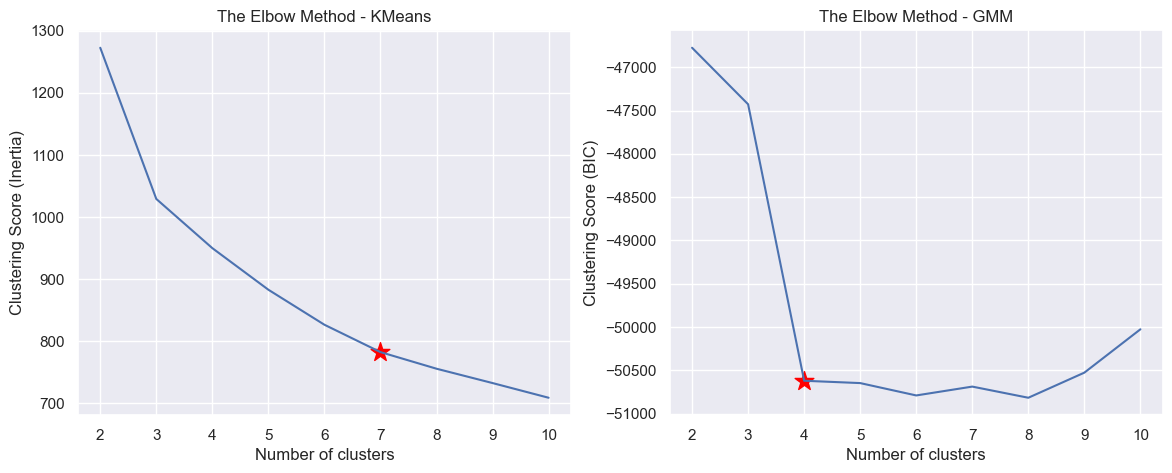

In [940]:
figure, axis = plt.subplots(1, 2, figsize=(14, 5))
axis[0].plot(range(2, 11), kbest_scores)
axis[0].set_title('The Elbow Method - KMeans')
axis[0].set_xlabel('Number of clusters')
axis[0].set_ylabel('Clustering Score (Inertia)')
axis[0].scatter(7, kbest_scores[5], s = 200, c = 'red', marker='*')
axis[1].plot(range(2, 11), gmm_scores)
axis[1].scatter(4, gmm_scores[2], s = 200, c = 'red', marker='*')
axis[1].set_title('The Elbow Method - GMM')
axis[1].set_xlabel('Number of clusters')
axis[1].set_ylabel('Clustering Score (BIC)')

plt.show() 

## Plotting Kmeans and GMM silhouette scores

Text(0, 0.5, 'Silhouette score')

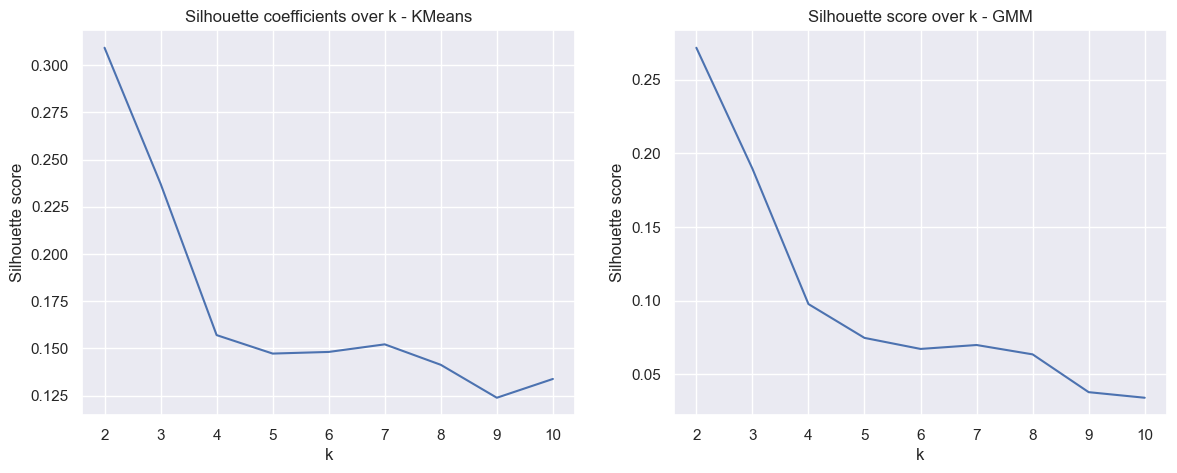

In [941]:
figure, axis = plt.subplots(1, 2, figsize=(14, 5))
axis[0].plot(range(2, 11), kmeans_silhouette_scores)
axis[0].set_title('Silhouette coefficients over k - KMeans')
axis[0].set_xlabel('k')
axis[0].set_ylabel('Silhouette score')

axis[1].plot(range(2, 11), gmm_silhouette_scores)
axis[1].set_title('Silhouette score over k - GMM')
axis[1].set_xlabel('k')
axis[1].set_ylabel('Silhouette score')

# Plotting models 

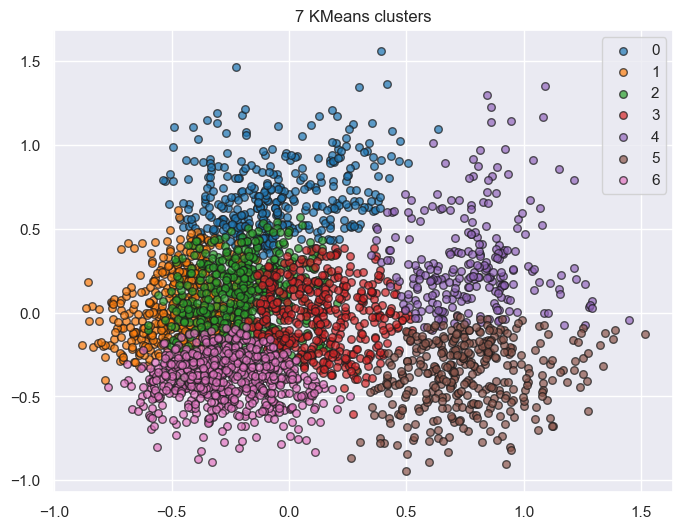

In [942]:
_, centers, kmeans_labels = kmeans(X_PCA, 7)

# map predictions to label
labels = np.unique(kmeans_labels)
colors = cycle(cm.tab10.colors)
plt.figure(figsize=(8, 6))
plt.title('7 KMeans clusters')


for label in labels:
    # plot one cluster for each iteration
    color = next(colors)
    # find indeces corresponding to cluser i
    idx = kmeans_labels == label
    # plot cluster
    plt.scatter(X_PCA[idx, 0], X_PCA[idx, 1], color=color, s=30, edgecolor='k', label=label, alpha=0.7)
    

plt.legend()

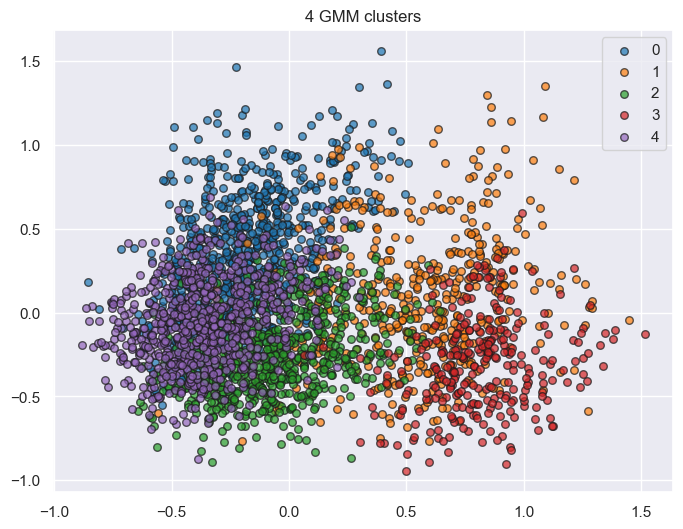

In [943]:
_, centers, gmm_labels = gmm(X_PCA, 5)

# map predictions to label
labels = np.unique(gmm_labels)
colors = cycle(cm.tab10.colors)
plt.figure(figsize=(8, 6))
plt.title('4 GMM clusters')


for label in labels:
    # plot one cluster for each iteration
    color = next(colors)
    # find indeces corresponding to cluser i
    idx = gmm_labels == label
    # plot cluster
    plt.scatter(X_PCA[idx, 0], X_PCA[idx, 1], color=color, s=30, edgecolor='k', label=label, alpha=0.7)
    

plt.legend()

# Listing clusters

In [944]:
def list_clusters(method, X, n_clusters, positions):
    
    score, centres, labels = method(X, n_clusters)
    
    sizes = pd.Series(labels).value_counts().to_dict()

    position_split = {}
    for i, label in enumerate(labels):
        position = positions[i]
        if label not in position_split:
            position_split[label] = {}
        if position not in position_split[label]:
            position_split[label][position] = 0
        position_split[label][position] += 1

    # position_split = dict(sorted(position_split.values()))

    print('\nThere are {} clusters with a total score of {:.1f}\n'
          .format(len(sizes), score))

    # Print positions present in each cluster
    for label, _ in enumerate(centres):
        # sort keys of dictionary for easier visibility
        sorted_positions = dict(sorted(position_split[label].items(),))

        print('Cluster {} has {} players with positions {}\n'
                .format(label, sizes[label], sorted_positions))

    return

### Listing Kmeans clusters

In [945]:
positions = list(df_copy['pos'])
list_clusters(kmeans, X_PCA, 7, positions)


There are 7 clusters with a total score of 782.3

Cluster 0 has 355 players with positions {'C': 10, 'PF': 33, 'PG': 148, 'PG-SG': 1, 'SF': 69, 'SG': 94}

Cluster 1 has 564 players with positions {'C': 4, 'PF': 56, 'PF-SF': 1, 'PG': 76, 'PG-SG': 1, 'SF': 117, 'SF-PF': 1, 'SF-SG': 6, 'SG': 300, 'SG-PF': 1, 'SG-SF': 1}

Cluster 2 has 463 players with positions {'PF': 8, 'PF-SF': 1, 'PG': 324, 'PG-SG': 2, 'SF': 20, 'SF-SG': 1, 'SG': 100, 'SG-PG': 6, 'SG-SF': 1}

Cluster 3 has 442 players with positions {'C': 74, 'C-PF': 1, 'PF': 220, 'PF-SF': 1, 'PG': 3, 'SF': 102, 'SF-PF': 2, 'SG': 38, 'SG-SF': 1}

Cluster 4 has 251 players with positions {'C': 148, 'PF': 92, 'PF-C': 1, 'PG': 5, 'SF': 3, 'SG': 2}

Cluster 5 has 366 players with positions {'C': 287, 'C-PF': 1, 'PF': 71, 'PG': 1, 'SF': 5, 'SG': 1}

Cluster 6 has 649 players with positions {'C': 15, 'C-PF': 1, 'PF': 127, 'PF-C': 2, 'PF-SF': 3, 'PG': 73, 'SF': 238, 'SF-PF': 1, 'SF-SG': 4, 'SG': 183, 'SG-SF': 2}



### Listing GMM clusters

In [946]:
list_clusters(gmm, X_PCA, 4, positions)


There are 4 clusters with a total score of -50620.5

Cluster 0 has 1010 players with positions {'C': 39, 'C-PF': 2, 'PF': 308, 'PF-C': 2, 'PF-SF': 4, 'PG': 20, 'SF': 361, 'SF-PF': 2, 'SF-SG': 5, 'SG': 263, 'SG-PF': 1, 'SG-SF': 3}

Cluster 1 has 599 players with positions {'C': 270, 'PF': 207, 'PF-C': 1, 'PG': 51, 'PG-SG': 1, 'SF': 41, 'SF-SG': 1, 'SG': 27}

Cluster 2 has 1192 players with positions {'C': 1, 'PF': 37, 'PF-SF': 2, 'PG': 557, 'PG-SG': 3, 'SF': 149, 'SF-PF': 2, 'SF-SG': 5, 'SG': 428, 'SG-PG': 6, 'SG-SF': 2}

Cluster 3 has 289 players with positions {'C': 228, 'C-PF': 1, 'PF': 55, 'PG': 2, 'SF': 3}



# Merging cluster predictions into original dataset

In [963]:
# use copy of original dataset to view desired original features
df_cluster = df_copy.copy()

# drop features that are not of interest
df_cluster = df_cluster.drop(
  ['seas_id', 'birth_year','lg','player_id'], axis=1)
# fill null values
df_cluster['x3p%'] = df_cluster['x3p%'].fillna(0)


In [965]:
# merge cluster labels into copy of original dataset
df_cluster['kmeans cluster'] = pd.Series(kmeans_labels, index=df.index)
df_cluster['gmm cluster'] = pd.Series(gmm_labels, index=df.index)

df_cluster.sample(10)

,season,player,pos,age,experience,tm,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg,kmeans cluster,gmm cluster
6773,2013,Gerald Wallace,SF,30,12,BRK,69,68.0,2076,4.7,11.9,0.397,1.2,4.2,0.282,3.5,7.7,0.461,3.2,4.9,0.637,1.8,6.5,8.3,4.7,2.5,1.2,2.9,3.1,13.8,101.0,104.0,6,2
3348,2019,Serge Ibaka,C,29,10,TOR,74,51.0,2010,11.1,20.9,0.529,1.2,4.0,0.290,9.9,16.9,0.586,3.2,4.2,0.763,3.7,10.6,14.3,2.4,0.7,2.5,2.7,5.0,26.5,113.0,105.0,4,1
1065,2022,Kessler Edwards,SF,21,1,BRK,48,23.0,987,5.4,13.1,0.412,2.4,6.7,0.353,3.0,6.4,0.473,0.8,0.9,0.842,2.2,6.3,8.4,1.5,1.4,1.2,2.1,4.2,13.9,100.0,113.0,6,2
3614,2018,Dejounte Murray,PG,21,2,SAS,81,48.0,1743,7.8,17.7,0.443,0.3,1.0,0.265,7.6,16.7,0.454,3.0,4.3,0.709,3.2,10.1,13.3,6.7,2.8,0.9,3.9,4.4,19.0,99.0,101.0,3,2
6205,2014,J.J. Hickson,PF,25,6,DEN,69,52.0,1859,8.7,17.2,0.508,0.0,0.2,0.000,8.7,17.0,0.514,3.9,7.6,0.517,5.4,11.2,16.6,2.5,1.2,1.3,3.4,4.7,21.4,103.0,106.0,5,3
2042,2021,Terence Davis,SG,23,2,TOT,61,4.0,1074,8.7,20.5,0.428,4.4,12.0,0.367,4.4,8.5,0.513,2.0,2.5,0.818,0.9,6.0,6.9,3.7,2.0,0.6,2.8,4.4,23.9,104.0,115.0,1,4
1501,2021,Caris LeVert,SG,26,5,IND,35,35.0,1152,11.2,25.2,0.443,2.5,8.0,0.318,8.6,17.2,0.501,4.9,6.0,0.822,0.9,5.7,6.6,7.1,2.2,1.0,3.1,3.5,29.8,107.0,112.0,0,0
4525,2017,Markieff Morris,PF,27,6,WAS,76,76.0,2374,8.4,18.5,0.457,1.5,4.1,0.362,7.0,14.4,0.483,3.7,4.5,0.837,2.2,8.0,10.2,2.6,1.7,0.9,2.7,5.3,22.1,106.0,109.0,3,2
4695,2017,Trevor Ariza,SF,31,13,HOU,80,80.0,2773,5.6,13.8,0.409,3.3,9.6,0.344,2.3,4.2,0.556,1.6,2.2,0.738,0.9,7.0,7.9,3.0,2.5,0.3,1.3,2.3,16.2,113.0,108.0,6,2
6635,2013,Brian Roberts,PG,27,1,NOH,78,5.0,1324,8.7,20.9,0.417,2.4,6.3,0.386,6.3,14.7,0.430,2.9,3.2,0.909,0.7,3.3,4.0,9.0,1.5,0.1,2.9,4.4,22.7,109.0,113.0,2,0


In [956]:
# df_cluster[df_cluster["player"] == 'Marc Gasol']

# View data samples from each kmeans cluster 

In [966]:
df_cluster[df_cluster["kmeans cluster"] == 0].sample(5)

,season,player,pos,age,experience,tm,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg,kmeans cluster,gmm cluster
1271,2022,Russell Westbrook,PG,33,14,LAL,78,78.0,2678,9.8,22.1,0.444,1.4,4.7,0.298,8.4,17.3,0.485,4.8,7.1,0.667,2.0,8.4,10.4,9.8,1.3,0.4,5.3,4.2,25.8,102.0,114.0,0,0
289,2023,Jordan Clarkson,SG,30,9,UTA,58,58.0,1886,11.2,25.1,0.446,3.9,11.3,0.345,7.3,13.8,0.529,4.8,5.9,0.818,1.7,4.3,6.0,6.2,0.8,0.3,4.4,2.9,31.1,110.0,120.0,0,0
365,2023,Kyrie Irving,PG,30,12,TOT,44,44.0,1632,13.1,26.8,0.490,4.3,11.5,0.379,8.8,15.3,0.573,5.3,5.9,0.893,1.3,5.4,6.7,7.2,1.4,1.1,3.0,3.6,35.9,120.0,115.0,0,0
3525,2018,Blake Griffin,PF,28,8,LAC,33,33.0,1139,10.9,24.7,0.441,2.7,8.0,0.342,8.2,16.7,0.488,7.3,9.3,0.785,2.0,9.2,11.2,7.6,1.3,0.4,4.2,3.3,31.8,110.0,110.0,0,0
575,2023,Tyrese Haliburton,PG,22,3,IND,48,48.0,1605,10.2,21.3,0.481,4.1,10.2,0.399,6.1,11.0,0.556,3.8,4.4,0.864,0.9,4.4,5.4,14.3,2.5,0.6,3.7,1.7,28.3,125.0,116.0,0,0


In [967]:
df_cluster[df_cluster["kmeans cluster"] == 1].sample(5)

,season,player,pos,age,experience,tm,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg,kmeans cluster,gmm cluster
2170,2020,Bogdan Bogdanović,SG,27,3,SAC,61,28.0,1766,9.3,21.0,0.440,4.5,12.1,0.372,4.8,8.9,0.532,2.4,3.2,0.741,0.7,5.0,5.7,5.7,1.8,0.4,2.8,3.7,25.4,110.0,113.0,1,4
677,2022,Buddy Hield,SG,29,6,TOT,81,32.0,2499,8.6,21.3,0.406,5.1,13.9,0.366,3.6,7.4,0.482,2.2,2.5,0.874,1.3,5.6,6.8,4.4,1.4,0.5,3.0,3.6,24.5,105.0,117.0,1,4
6966,2013,Marco Belinelli,SG,26,6,CHI,73,27.0,1882,6.9,17.4,0.395,2.3,6.3,0.357,4.6,11.1,0.416,4.0,4.8,0.839,0.4,3.6,4.0,4.2,1.3,0.2,2.3,4.0,20.0,104.0,107.0,1,4
6805,2013,J.J. Redick,SG,28,7,ORL,50,11.0,1575,8.7,19.2,0.450,3.9,9.9,0.390,4.8,9.3,0.514,3.8,4.3,0.891,0.3,3.6,3.9,7.3,1.0,0.2,3.5,2.3,25.0,112.0,113.0,1,0
5569,2015,J.R. Smith,SG,29,11,CLE,46,45.0,1461,7.6,17.9,0.425,4.7,12.0,0.390,3.0,6.0,0.494,1.0,1.2,0.818,0.9,4.8,5.7,4.1,2.3,0.6,1.9,4.2,20.9,113.0,107.0,1,4


In [968]:
df_cluster[df_cluster["kmeans cluster"] == 2].sample(5)

,season,player,pos,age,experience,tm,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg,kmeans cluster,gmm cluster
5750,2015,Michael Carter-Williams,PG,23,2,PHI,41,38.0,1391,8.4,22.0,0.380,1.2,4.5,0.256,7.2,17.5,0.412,4.2,6.6,0.643,1.5,7.6,9.2,10.9,2.2,0.6,6.3,3.7,22.1,88.0,105.0,2,0
4942,2016,Ish Smith,PG,27,6,TOT,77,53.0,2239,8.7,21.2,0.411,1.2,3.7,0.329,7.5,17.5,0.428,2.7,3.9,0.693,0.9,5.8,6.7,11.0,1.9,0.5,3.8,2.9,21.3,98.0,110.0,2,0
5764,2015,Mo Williams,PG,32,12,TOT,68,33.0,1980,8.8,22.2,0.397,3.1,9.0,0.342,5.7,13.2,0.434,4.2,4.8,0.872,0.6,3.9,4.5,11.0,1.2,0.4,4.4,4.2,24.9,102.0,112.0,2,0
4081,2018,Tony Parker,PG,35,17,SAS,55,21.0,1071,8.4,18.3,0.459,0.5,1.7,0.270,7.9,16.6,0.479,2.6,3.7,0.705,0.3,4.2,4.5,9.2,1.3,0.0,3.2,2.5,19.9,103.0,109.0,2,0
2854,2019,Caris LeVert,SF,24,3,BRK,40,25.0,1063,9.3,21.6,0.429,2.1,6.9,0.312,7.1,14.7,0.483,3.8,5.5,0.691,1.6,5.2,6.8,7.0,1.9,0.6,3.1,3.4,24.5,105.0,110.0,2,0


In [969]:
df_cluster[df_cluster["kmeans cluster"] == 3].sample(5)

,season,player,pos,age,experience,tm,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg,kmeans cluster,gmm cluster
3866,2018,Kyle Kuzma,PF,22,1,LAL,77,37.0,2401,9.3,20.7,0.450,3.2,8.6,0.366,6.2,12.1,0.511,2.9,4.1,0.707,1.8,7.9,9.6,2.8,1.0,0.7,2.8,3.2,24.7,105.0,109.0,3,4
3417,2019,Trey Lyles,PF,23,4,DEN,64,2.0,1120,9.1,21.7,0.418,2.2,8.8,0.255,6.8,12.9,0.529,3.6,5.1,0.698,1.9,8.9,10.8,3.8,1.3,1.0,3.0,4.1,23.9,100.0,109.0,3,2
5279,2016,Tobias Harris,PF,23,5,ORL,49,49.0,1610,7.8,16.8,0.464,1.5,4.7,0.311,6.3,12.1,0.523,3.7,4.8,0.784,2.2,8.4,10.6,3.1,1.5,0.9,2.4,2.8,20.8,107.0,107.0,3,4
5806,2015,Paul Millsap,PF,29,9,ATL,73,73.0,2390,9.5,19.9,0.476,1.6,4.6,0.356,7.8,15.3,0.513,5.5,7.2,0.757,3.0,9.2,12.2,4.8,2.8,1.5,3.5,4.3,26.0,109.0,99.0,3,2
3324,2019,Rodions Kurucs,SF,20,1,BRK,63,46.0,1294,7.4,16.5,0.450,2.1,6.8,0.315,5.3,9.7,0.543,2.6,3.4,0.783,2.1,7.0,9.0,1.9,1.5,0.9,2.8,5.4,19.6,102.0,109.0,3,2


In [970]:
df_cluster[df_cluster["kmeans cluster"] == 4].sample(5)

,season,player,pos,age,experience,tm,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg,kmeans cluster,gmm cluster
5961,2015,Zach Randolph,PF,33,14,MEM,71,71.0,2304,10.3,21.1,0.487,0.2,0.5,0.350,10.1,20.7,0.490,5.2,6.8,0.765,5.1,11.8,16.9,3.5,1.6,0.3,3.5,4.0,25.9,107.0,101.0,4,1
5482,2015,Dwight Howard,C,29,11,HOU,41,41.0,1223,10.2,17.2,0.593,0.0,0.1,0.500,10.2,17.1,0.594,5.8,11.0,0.528,4.5,13.0,17.5,2.0,1.1,2.2,4.7,5.6,26.3,105.0,100.0,4,1
3971,2018,Nikola Vučević,C,27,7,ORL,57,57.0,1683,11.6,24.4,0.475,1.9,5.9,0.314,9.7,18.5,0.527,2.2,2.7,0.819,2.9,12.3,15.2,5.6,1.6,1.8,3.2,4.2,27.3,105.0,106.0,4,1
5408,2015,Carlos Boozer,PF,33,13,LAL,71,26.0,1692,11.2,22.4,0.499,0.0,0.0,0.000,11.2,22.4,0.499,2.8,4.5,0.627,3.4,11.2,14.5,2.9,1.2,0.4,2.8,5.6,25.2,102.0,109.0,4,3
4975,2016,Jared Sullinger,PF,23,4,BOS,81,73.0,1915,8.9,20.5,0.435,0.7,2.6,0.282,8.2,17.9,0.458,2.6,4.1,0.640,4.9,12.2,17.1,4.8,1.9,1.2,2.6,5.3,21.2,103.0,100.0,4,1


In [958]:
df_cluster[df_cluster["kmeans cluster"] == 5].sample(5)

,seas_id,season,player_id,player,birth_year,pos,age,experience,lg,tm,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg,kmeans cluster,gmm cluster
498,30956,2023,4199,Rudy Gobert,NaN,C,30,10,NBA,MIN,50,50.0,1524,7.9,11.7,0.676,0.0,0.1,0.000,7.9,11.6,0.682,4.9,7.2,0.670,4.9,13.1,18.0,1.4,1.2,2.0,2.7,4.6,20.7,128.0,109.0,5,3
3523,26963,2018,3984,Bismack Biyombo,NaN,C,25,7,NBA,ORL,82,25.0,1495,6.0,11.5,0.520,0.0,0.0,0.000,6.0,11.5,0.521,3.3,5.1,0.650,4.7,10.6,15.3,2.2,0.7,3.1,2.8,5.2,15.3,108.0,107.0,5,3
2099,29626,2021,4682,Wendell Carter Jr.,NaN,C,21,3,NBA,TOT,54,44.0,1375,8.1,16.1,0.503,0.5,1.8,0.294,7.6,14.3,0.530,4.6,6.3,0.732,4.7,11.0,15.6,3.7,1.2,1.5,2.8,5.2,21.4,114.0,111.0,5,1
5891,25670,2015,4293,Tarik Black,NaN,C,23,1,NBA,TOT,63,39.0,1196,6.6,11.6,0.575,0.0,0.0,0.000,6.6,11.5,0.577,2.8,5.0,0.551,6.0,9.6,15.6,1.8,0.8,1.0,2.0,6.7,16.0,118.0,108.0,5,3
904,29948,2022,4840,Isaiah Stewart,NaN,C,20,2,NBA,DET,71,71.0,1816,6.7,13.2,0.510,0.4,1.2,0.326,6.3,11.9,0.529,2.0,2.8,0.718,6.1,10.5,16.6,2.2,0.6,2.1,2.3,5.7,15.8,113.0,112.0,5,1


In [971]:
df_cluster[df_cluster["kmeans cluster"] == 6].sample(5)

,season,player,pos,age,experience,tm,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg,kmeans cluster,gmm cluster
6835,2013,Jason Kidd,SG,39,19,NYK,76,48.0,2043,4.0,10.7,0.372,3.0,8.5,0.351,1.0,2.2,0.452,1.0,1.3,0.833,1.3,7.1,8.5,6.5,3.3,0.7,2.0,3.3,12.0,114.0,103.0,6,2
1584,2021,Deni Avdija,SF,20,1,WAS,54,32.0,1257,4.8,11.4,0.417,1.9,6.2,0.315,2.8,5.3,0.535,1.1,1.7,0.644,0.8,8.8,9.6,2.3,1.2,0.6,1.2,5.1,12.5,103.0,113.0,6,2
4799,2016,Brandon Rush,SG,30,8,GSW,72,25.0,1055,5.1,11.9,0.427,3.0,7.2,0.414,2.1,4.7,0.447,0.8,1.3,0.643,1.0,7.3,8.3,2.6,0.9,1.1,1.5,2.6,14.0,108.0,106.0,6,2
2512,2020,Kyle Anderson,SF,26,6,MEM,67,28.0,1330,5.5,11.6,0.474,0.8,3.0,0.282,4.7,8.6,0.541,1.8,2.7,0.667,2.0,8.0,10.0,5.7,1.9,1.3,2.3,3.9,13.7,109.0,109.0,6,2
571,2023,Troy Brown Jr.,SF,23,5,LAL,53,31.0,1279,5.2,11.9,0.438,2.5,6.8,0.362,2.7,5.1,0.540,1.0,1.0,0.963,1.8,6.6,8.3,2.1,1.4,0.3,1.4,3.0,13.8,112.0,115.0,6,4


# Creating dataframe with means of columns for each cluster

### Selecting columns to include in means dataframe

In [972]:
df_copy.columns

Index(['seas_id', 'season', 'player_id', 'player', 'birth_year', 'pos', 'age',
       'experience', 'lg', 'tm', 'g', 'gs', 'mp', 'fg', 'fga', 'fg%', 'x3p',
       'x3pa', 'x3p%', 'x2p', 'x2pa', 'x2p%', 'ft', 'fta', 'ft%', 'orb', 'drb',
       'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 'o_rtg', 'd_rtg'],
      dtype='object')

In [973]:
selected_columns = [
  'age', 'experience', 'g',
  'gs', 'mp', 'fg', 'fga', 'fg%', 'x3p', 'x3pa', 'x3p%', 'x2p', 'x2pa',
  'x2p%', 'ft', 'fta', 'ft%', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk',
  'tov', 'pf', 'pts', 'o_rtg', 'd_rtg'
]

### Creating new df with means of all columns for kmeans clusters

In [974]:
df_cluster_grouped_kmeans = df_cluster.groupby(['kmeans cluster'])[selected_columns].mean()

df_cluster_grouped_kmeans


,age,experience,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg
kmeans cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,26.847887,7.614085,62.377465,56.366197,2101.287324,11.476056,25.050986,0.458161,3.042817,8.329859,0.357645,8.436338,16.718028,0.505304,6.746197,8.125915,0.829048,1.260845,6.303099,7.567324,7.962535,1.737183,0.634930,4.088451,3.193803,32.736901,112.628169,110.394366
1,26.854610,6.310284,64.764184,33.953901,1731.329787,8.208688,19.154610,0.428959,3.731028,9.851064,0.378603,4.476418,9.304078,0.482562,3.043972,3.676418,0.826807,0.939894,4.959574,5.898759,4.016135,1.380674,0.474291,2.268440,3.476418,23.191844,109.969858,112.597518
2,26.639309,6.302376,65.725702,36.622030,1763.352052,7.753780,18.016847,0.430853,1.855940,5.417927,0.332389,5.894816,12.600864,0.468451,3.520086,4.444276,0.785099,1.030022,4.870194,5.899568,8.451404,1.880778,0.459611,3.580778,3.697408,20.875810,105.393089,109.814255
3,25.592760,5.723982,66.579186,41.201357,1748.377828,8.456561,18.124661,0.468208,1.873756,5.389819,0.342726,6.585520,12.737104,0.520783,3.428507,4.542534,0.753986,2.522851,8.055204,10.578733,3.357240,1.480317,1.226923,2.542534,4.264480,22.216063,109.047511,108.404977
4,26.478088,6.852590,67.709163,53.605578,1974.003984,11.105179,21.427888,0.520689,0.502390,1.588446,0.240725,10.603187,19.841036,0.537267,5.366932,7.318725,0.735159,4.204781,10.896813,15.099203,4.244622,1.448207,1.789243,3.511952,4.619522,28.087251,111.665339,105.183267
5,26.133880,6.032787,68.551913,40.849727,1590.636612,7.339891,13.045628,0.565904,0.077869,0.317213,0.093743,7.258197,12.722951,0.574251,3.226776,4.987158,0.648161,5.142350,10.046175,15.189344,2.658470,1.329508,2.223224,2.497814,5.453825,17.984699,117.374317,105.956284
6,27.092450,5.992296,66.164869,32.493066,1585.807396,5.602003,13.059322,0.430422,2.308012,6.438367,0.354467,3.293991,6.620339,0.500066,1.881818,2.485824,0.756641,1.481048,5.765794,7.243606,3.638521,1.669029,0.785516,1.965794,4.123267,15.396918,108.693374,109.906009


### Creating new df with means of all columns for gmm clusters

In [975]:
df_cluster_grouped_gmm = df_cluster.groupby(['gmm cluster'])[selected_columns].mean()

df_cluster_grouped_gmm


,age,experience,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg
gmm cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,26.868243,6.789414,64.003378,43.138514,1864.394144,8.944144,20.295045,0.438082,2.522185,7.014865,0.350994,6.421171,13.280743,0.480135,4.622635,5.651351,0.809747,1.061036,5.198649,6.259685,8.190315,1.825113,0.474550,3.659685,3.505743,25.029730,109.069820,110.501126
1,26.401691,6.668076,66.668076,46.822410,1804.452431,9.582452,18.645666,0.519129,0.898309,2.684355,0.300264,8.680973,15.964482,0.548573,4.560254,6.153277,0.738381,3.766173,9.821142,13.585412,4.074841,1.377167,1.883721,3.033827,4.687526,24.629387,113.970402,106.699789
2,26.300604,5.664653,66.148036,34.335347,1613.586103,6.773263,15.126133,0.447846,2.191390,6.228097,0.345523,4.582931,8.897432,0.516381,2.390332,3.233535,0.735728,2.183082,7.240785,9.423716,3.382175,1.727644,1.040030,2.218278,4.405891,18.127190,108.963746,108.743202
3,26.361111,6.336806,68.975694,44.093750,1662.638889,7.719444,14.066667,0.555819,0.000000,0.040972,0.000000,7.719444,14.017361,0.557660,3.419097,5.293403,0.645764,5.186458,10.321528,15.509375,2.626736,1.300347,2.201042,2.663542,5.312500,18.857986,114.822917,105.211806
4,26.658537,6.121951,66.151476,35.863928,1748.853659,7.649551,17.678691,0.432678,3.092683,8.297176,0.369979,4.557381,9.381386,0.487696,2.794994,3.472786,0.807272,1.034531,5.104365,6.137612,3.456483,1.365212,0.495250,2.135558,3.524904,21.186521,108.557125,111.785623


# Visualisation of data

In [976]:
# get cluster numbers
clusters = df_cluster_grouped_kmeans.index
# load colors for each cluster
cluster_colors = cm.tab10.colors

# Usage

## Games started

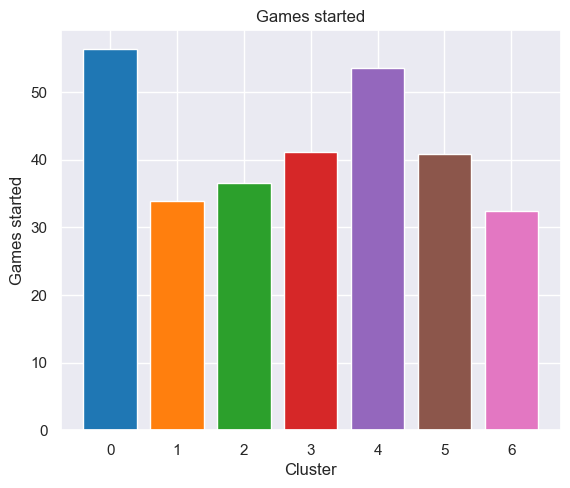

In [977]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_axes([1,1,1,1])

# getting games started for each cluster
gs = df_cluster_grouped_kmeans['gs']

ax.bar(clusters,gs, color=cluster_colors)
ax.set_title('Games started')
ax.set_xlabel('Cluster')
ax.set_ylabel('Games started')
plt.show()

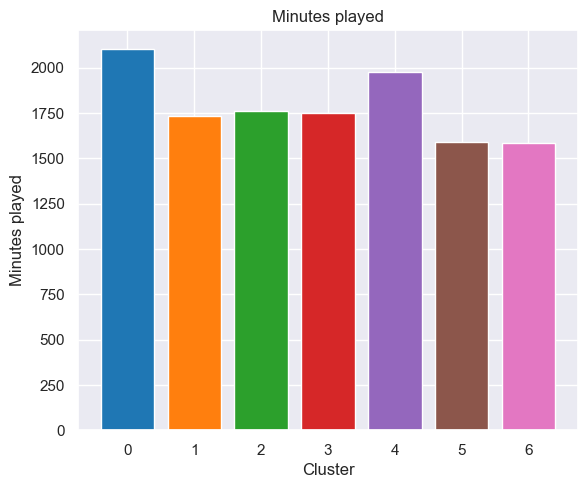

In [978]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_axes([1,1,1,1])

# getting minutes played for each cluster
mp = df_cluster_grouped_kmeans['mp']

ax.bar(clusters,mp, color=cluster_colors)
ax.set_title('Minutes played')
ax.set_xlabel('Cluster')
ax.set_ylabel('Minutes played')
plt.show()

# Offensive stats

## Points scored

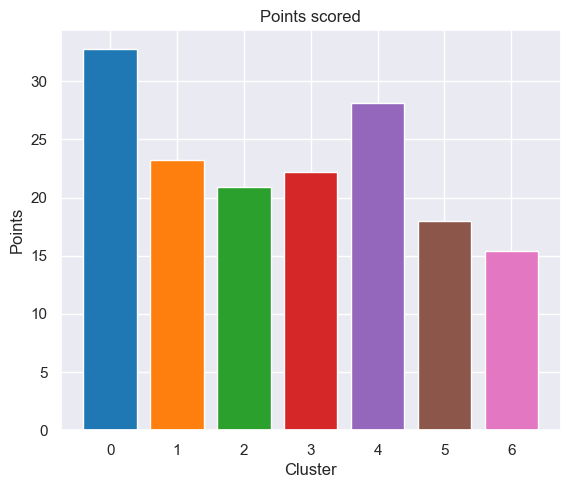

In [979]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_axes([1,1,1,1])

# getting points for each cluster
points = df_cluster_grouped_kmeans['pts']

ax.bar(clusters,points, color=cluster_colors)
ax.set_title('Points scored')
ax.set_xlabel('Cluster')
ax.set_ylabel('Points')
plt.show()

## Assists

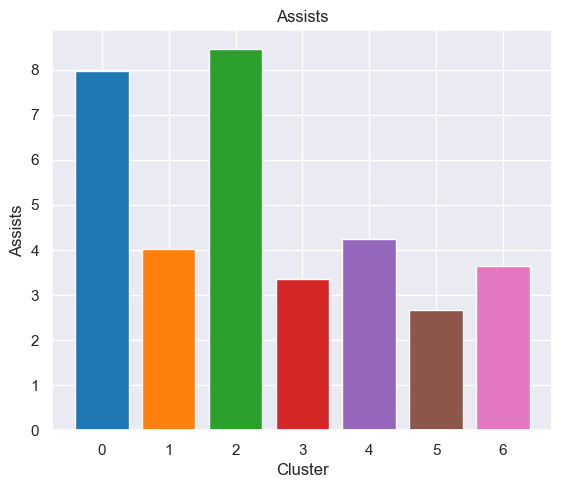

In [980]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_axes([1,1,1,1])

# getting assists for each cluster
assists = df_cluster_grouped_kmeans['ast']

ax.bar(clusters,assists, color=cluster_colors)
ax.set_title('Assists')
ax.set_xlabel('Cluster')
ax.set_ylabel('Assists')
plt.show()

## Turnovers

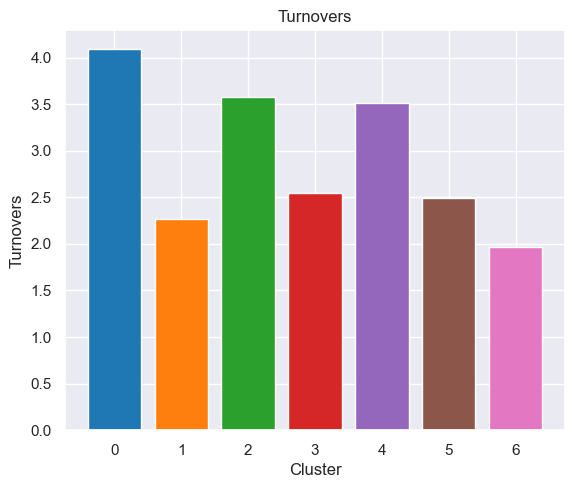

In [991]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_axes([1,1,1,1])

# getting turnovers for each cluster
turnovers = df_cluster_grouped_kmeans['tov']

ax.bar(clusters,turnovers, color=cluster_colors)
ax.set_title('Turnovers')
ax.set_xlabel('Cluster')
ax.set_ylabel('Turnovers')
plt.show()

# Rebounds

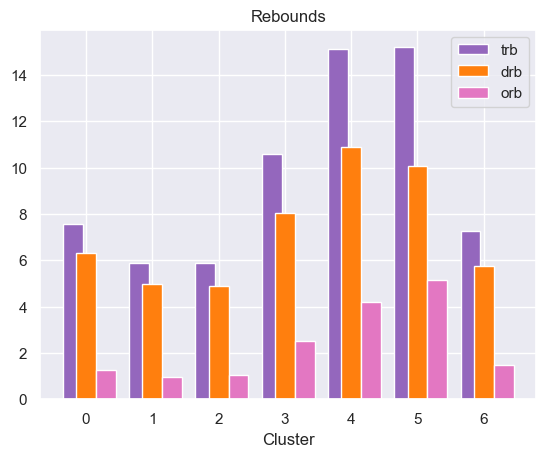

In [981]:
# get all the different rebound stats for each cluster
total_rebounds = df_cluster_grouped_kmeans['trb']
defensive_rebounds = df_cluster_grouped_kmeans['drb']
offensive_rebounds = df_cluster_grouped_kmeans['orb']

ax = plt.subplot(111)
x=clusters 
w = 0.3
ax.bar(x-0.2, total_rebounds, width=w, color=cluster_colors[4], align='center')
ax.bar(x, defensive_rebounds, width=w, color=cluster_colors[1], align='center')
ax.bar(x+w, offensive_rebounds, width=w, color=cluster_colors[6], align='center')
ax.legend(('trb', 'drb','orb') )
ax.set_xlabel('Cluster')
ax.set_title('Rebounds')

plt.show()


# Shooting

## Shooting attempts

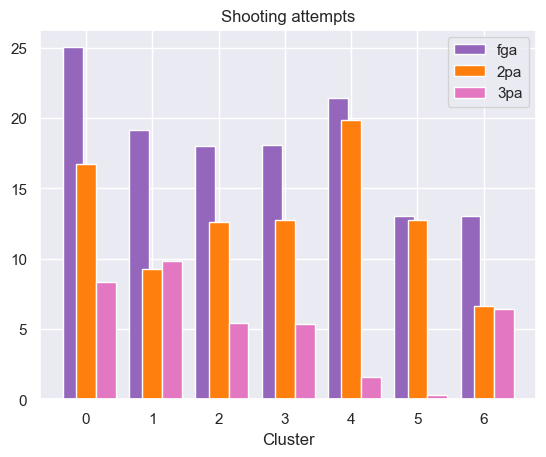

In [982]:
# getting shooting attemps for each cluster
fg_percent = df_cluster_grouped_kmeans['fga']
two_point_attempts = df_cluster_grouped_kmeans['x2pa']
three_point_attempts = df_cluster_grouped_kmeans['x3pa']

ax = plt.subplot(111)
x=clusters 
w = 0.3
ax.bar(x-0.2, fg_percent, width=w, color=cluster_colors[4], align='center')
ax.bar(x, two_point_attempts, width=w, color=cluster_colors[1], align='center')
ax.bar(x+w, three_point_attempts, width=w, color=cluster_colors[6], align='center')
ax.legend(('fga', '2pa','3pa') )
ax.set_xlabel('Cluster')
ax.set_title('Shooting attempts')

plt.show()


## Shooting accuracy

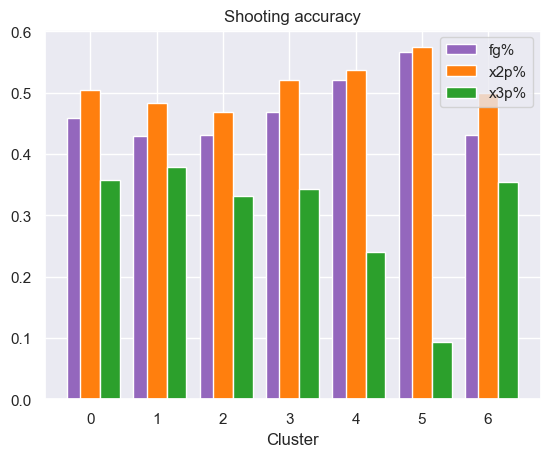

In [983]:
# getting shooting accuracy columns for each cluster
fg_percent = df_cluster_grouped_kmeans['fg%']
x2p_percent = df_cluster_grouped_kmeans['x2p%']
x3p_percent = df_cluster_grouped_kmeans['x3p%']

ax = plt.subplot(111)
x=clusters 
w = 0.3
ax.bar(x-0.2, fg_percent, width=w, color=cluster_colors[4], align='center')
ax.bar(x, x2p_percent, width=w, color=cluster_colors[1], align='center')
ax.bar(x+w, x3p_percent, width=w, color=cluster_colors[2], align='center')
ax.legend(('fg%', 'x2p%','x3p%') )
ax.set_xlabel('Cluster')
ax.set_title('Shooting accuracy')

plt.show()


# Free throws

## Free throw attempts

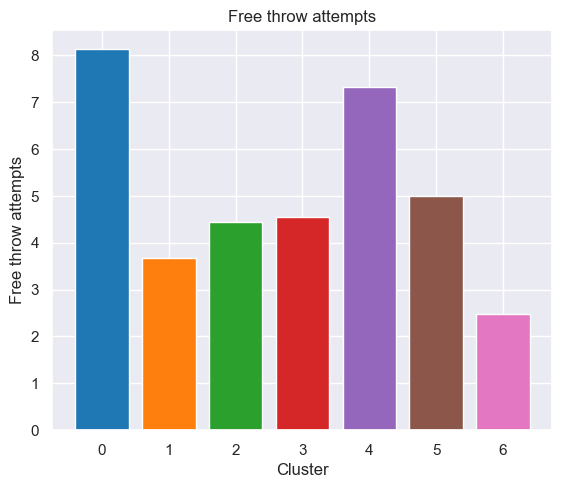

In [985]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_axes([1,1,1,1])

# getting free throw attempts for each cluster
turnovers = df_cluster_grouped_kmeans['fta']

ax.bar(clusters,turnovers, color=cluster_colors)
ax.set_title('Free throw attempts')
ax.set_xlabel('Cluster')
ax.set_ylabel('Free throw attempts')
plt.show()

## Free throw accuracy

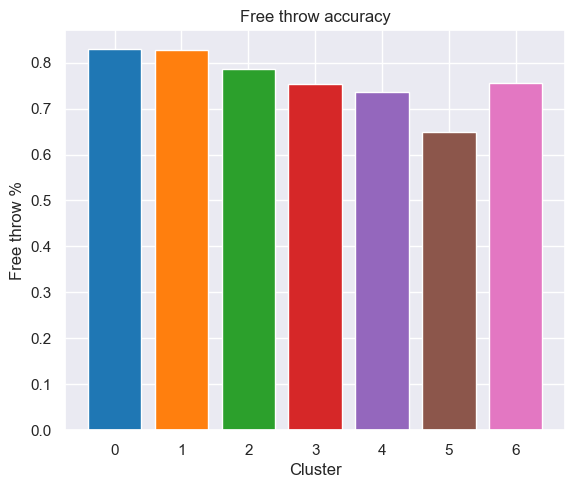

In [986]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_axes([1,1,1,1])

# getting free throw % for each cluster
turnovers = df_cluster_grouped_kmeans['ft%']

ax.bar(clusters,turnovers, color=cluster_colors)
ax.set_title('Free throw accuracy')
ax.set_xlabel('Cluster')
ax.set_ylabel('Free throw %')
plt.show()

# Defensive contributions

## Blocks and steals

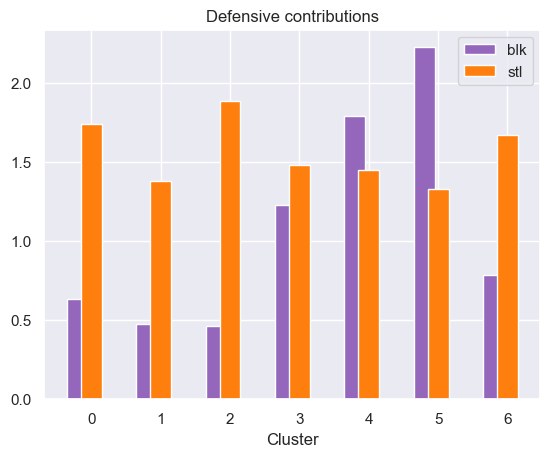

In [987]:
# getting blocks and steals for each cluster
blocks = df_cluster_grouped_kmeans['blk']
steals = df_cluster_grouped_kmeans['stl']

ax = plt.subplot(111)
x=clusters 
w = 0.3
ax.bar(x-0.2, blocks, width=w, color=cluster_colors[4], align='center')
ax.bar(x, steals, width=w, color=cluster_colors[1], align='center')
ax.legend(('blk','stl','pf') )
ax.set_xlabel('Cluster')
ax.set_title('Defensive contributions')

plt.show()


## Personal fouls

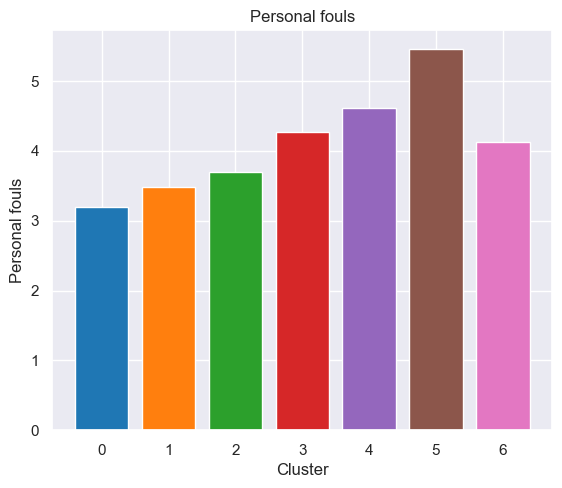

In [988]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_axes([1,1,1,1])

# getting personal fouls for each cluster
personal_fouls = df_cluster_grouped_kmeans['pf']

ax.bar(clusters,personal_fouls, color=cluster_colors)
ax.set_title('Personal fouls')
ax.set_xlabel('Cluster')
ax.set_ylabel('Personal fouls')
plt.show()

# Defensive and Offensive ratings

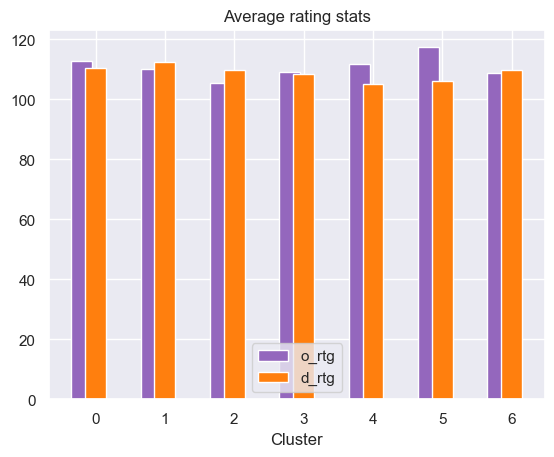

In [989]:
# getting offensive and defensive ratings for each cluset
o_rtg = df_cluster_grouped_kmeans['o_rtg']
d_rtg = df_cluster_grouped_kmeans['d_rtg']

ax = plt.subplot(111)
x=clusters 
w = 0.3
ax.bar(x-0.2, o_rtg, width=w, color=cluster_colors[4], align='center')
ax.bar(x, d_rtg, width=w, color=cluster_colors[1], align='center')
ax.legend(('o_rtg', 'd_rtg') )
ax.set_xlabel('Cluster')
ax.set_title('Average rating stats')

plt.show()
